In [12]:
# 1. Imports
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [13]:
# 2. Paths and Setup
vectorizer_type = "tfidf"
feature_count = 200000  # Based on previous best model

model_path = Path("../models/tuning_svm")
data_path = Path("../data_preparation")
report_path = Path("../reports/error_analysis")
report_path.mkdir(parents=True, exist_ok=True)


In [14]:
# 3. Load data and model
X_test = joblib.load(data_path / f"X_test_{vectorizer_type}_{feature_count}.joblib")
y_test = joblib.load(data_path / "y_test.joblib")
y_train = joblib.load(data_path / "y_train.joblib")
label_encoder = joblib.load(data_path / "label_encoder.joblib")
best_model = joblib.load(model_path / f"LinearSVC_best_{vectorizer_type}_{feature_count}.joblib")


In [15]:
# 4. Load original cleaned CSV and recreate split to get X_test_raw
clean_df = pd.read_csv(data_path / "cleaned_data.csv")
X_raw = clean_df["clean_text"]
y_raw = label_encoder.transform(clean_df["Category"])

X_train_raw, X_test_raw, _, _ = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

In [16]:
# 5. Predict and gather metadata
y_pred = best_model.predict(X_test)
decision_scores = best_model.decision_function(X_test)
confidences = np.max(decision_scores, axis=1)

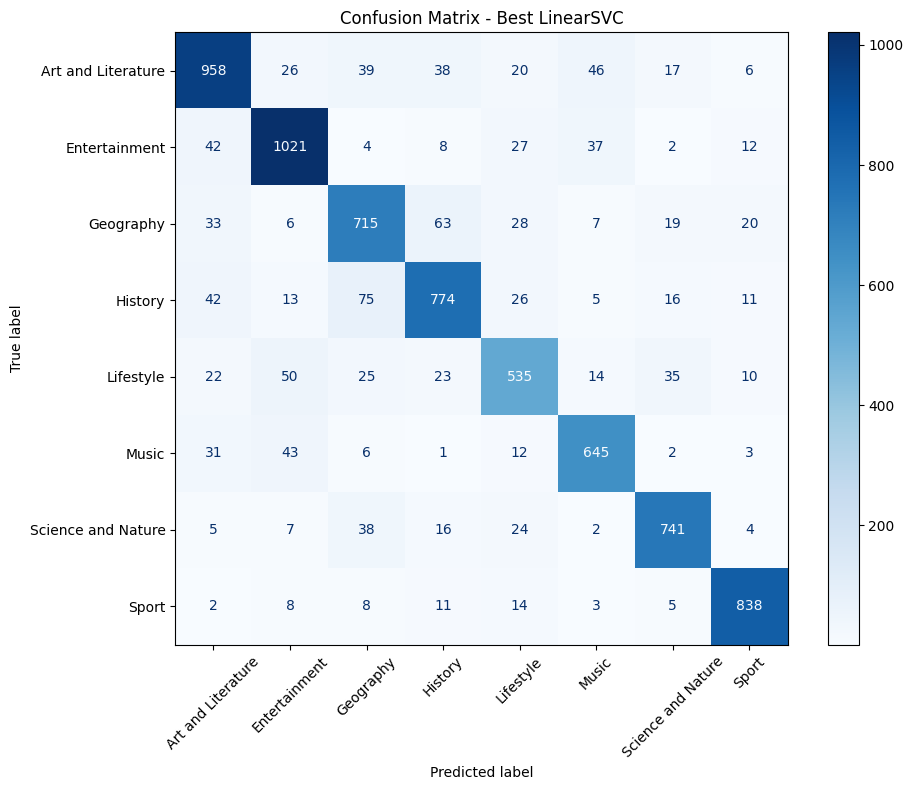

In [17]:
# 6. Save and show confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix - Best LinearSVC")
plt.tight_layout()
plt.savefig(report_path / "confusion_matrix.png")
plt.show()

In [18]:
# 7. Classification report by category
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)
with open(report_path / "classification_report.txt", "w") as f:
    f.write(report)

                    precision    recall  f1-score   support

Art and Literature       0.84      0.83      0.84      1150
     Entertainment       0.87      0.89      0.88      1153
         Geography       0.79      0.80      0.79       891
           History       0.83      0.80      0.82       962
         Lifestyle       0.78      0.75      0.76       714
             Music       0.85      0.87      0.86       743
Science and Nature       0.89      0.89      0.89       837
             Sport       0.93      0.94      0.93       889

          accuracy                           0.85      7339
         macro avg       0.85      0.85      0.85      7339
      weighted avg       0.85      0.85      0.85      7339



In [20]:
# 8. Find most confident wrong predictions
top_n = 25
wrong_indices = np.where(y_pred != y_test)[0]
wrong_confidences = confidences[wrong_indices]
sorted_wrong = wrong_indices[np.argsort(-wrong_confidences)[:top_n]]

# Build error dataframe from X_test_raw and original DataFrame
error_rows = []
for idx in sorted_wrong:
    original = clean_df.iloc[X_test_raw.index[idx]]
    error_rows.append({
        "Question": original["Question"],
        "Answer": original["Answer"],
        "True": original["Category"],
        "Predicted": label_encoder.inverse_transform([y_pred[idx]])[0],
        "Confidence": confidences[idx]
    })

error_df = pd.DataFrame(error_rows)
error_df.to_csv(report_path / "top_confident_errors.csv", index=False)

# Preview top errors
error_df.head(25)

,Question,Answer,True,Predicted,Confidence
0,Methane is a compound of hydrogen with which o...,Carbon,Entertainment,Science and Nature,2.235407
1,Which well known cartoon character was created...,POPEYE,History,Entertainment,2.136312
2,Which English cricket commentator on BBC's Tes...,Isa Guha,Entertainment,Sport,2.100330
3,"In 1924, prior to his career as a paediatricia...",ROWING,Science and Nature,Sport,2.019249
4,Oceanic Airlines are a fictitious airline who ...,LOST,Lifestyle,Entertainment,1.894728
5,"With 214 million followers, just behind Nation...",Nike,Sport,Lifestyle,1.861839
6,In 1976 which football team won their first ma...,SOUTHAMPTON,History,Sport,1.802026
7,"The German romantic author E.T.A. Hoffmann, wh...",The Nutcracker,Music,Art and Literature,1.797095
8,Which actor played West Ham football hooligan ...,Gary Oldman,Sport,Entertainment,1.766411
9,The Spanish word for aunt appears in the name ...,Tia Maria,Sport,Lifestyle,1.723021


## Findings

1. Many questions are labelled incorrectly in the Ground Truth data set (Carbon _should_ be Science and Nature, for instance)
2. Often, when the model is wrong, it is an edge case (Topkapi Palace could be Art or Geography, the E.T.A Hoffmann could be Music or Literature)

